<a href="https://colab.research.google.com/github/van-dang/VAWT-Cloud/blob/master/DFS_ALE_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [1]:
# !rm *.py *.xml *.txt *.zip *.pvd *.vtu *.geo *.msh
try:
    from google.colab import files
except:
    print("This is not google.colab")
    
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
    !sudo apt-get update
    !sudo apt-get install -y gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


This is not google.colab


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


dolfin version: 2019.1.0


# Working on the mesh

Info    : Running 'gmsh -2 simple_2D_turbine.geo -o simple_2D_turbine.msh' [Gmsh 3.0.6, 1 node, max. 1 thread]
Info    : Started on Wed Jul 10 11:29:10 2019
Info    : Reading 'simple_2D_turbine.geo'...
Info    : Finalized high order topology of periodic connections
Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 1000 (Nurb)
Info    : Meshing curve 1001 (Nurb)
Info    : Meshing curve 1002 (Nurb)
Info    : Done meshing 1D (0.1 s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (0.5 s)
Info    : 12814 vertices 25500 elements
Info    : Removing duplicate mesh vertices...
Info    : Found 1 duplicate vertices 
Info    : Removed 1 duplicate mesh vertex
Info    : Done removing duplicate mesh vertices
Info    : Done reading 'simple_2D_turbine.geo'
Info    : Finalized high order topology of periodic connections

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


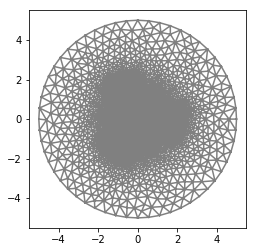

In [10]:
mesh_name='simple_2D_turbine'
is_geo_file_exist = os.path.isfile(mesh_name+'.geo')
if  is_geo_file_exist==False:
    !wget https://github.com/van-dang/VAWT-Cloud/raw/master/$mesh_name''.geo
!gmsh -2 $mesh_name''.geo -o $mesh_name''.msh
!dolfin-convert $mesh_name''.msh $mesh_name''.xml
mesh = Mesh(mesh_name+'.xml')
plot(mesh)

# Solve the Navier-Stokes equations

In [0]:
class Beta(Expression):
    def eval(self,values, x):
        values[0] = x[0]/k*(cos(rad_angle)-1)-x[1]/k*sin(rad_angle)
        values[1] = x[1]/k*(cos(rad_angle)-1)+x[0]/k*sin(rad_angle)
    def value_shape(self):
        return (2,)

beta = Beta()
betaf = interpolate(beta, V)
outfile_beta = File(sdir+"/iter%2.2d/beta.pvd" % i)
outfile_beta<<betaf;

# stop

while t<=T:
    mesh.rotate(rad_angle*180./pi);
    Z = FunctionSpace(mesh, "DG", 0)
    V = VectorFunctionSpace(mesh, "CG", 1)
    Q = FunctionSpace(mesh, "CG", 1)
    W = V * Q
    beta = Beta()
    betaf = interpolate(beta, V)
    #####################

    # primal solver boundary conditions
    bc_0_0 = DirichletBC(W.sub(0), u0_0, WallBoundary())
    # bc_0_1 = DirichletBC(W.sub(0), u0_0, InnerBoundary())
    bc_0_2 = DirichletBC(W.sub(0), Inflow(), InflowBoundary())
    bc_0_3p = DirichletBC(W.sub(1), u0_0p, OutflowBoundary())
    bc_0_3p_dual = DirichletBC(W.sub(0), u0_0, OutflowBoundary())
    bcs = [bc_0_0, bc_0_2, bc_0_3p]

    # Define unknown and test function(s)
    (v, q) = TestFunctions(W)
    wt = TestFunction(W)
    w = Function(W)

    u0 = project(u0, V)
    F = r_primal(W, w, wt, u0, k, betaf, ei_mode=False, stab=True)

    # Solve the primal problem
    solve(F == 0, w, bcs)        
    (u, p) = w.split()

    u.rename("u", "")
    p.rename("p", "")

    if istep % 5 == 0:
        print 't=',t
        outfile_ut << u
        outfile_pt << p

    u0 = u;
    t += k;
    istep +=1
